In [1]:
import os
import time

from jax import numpy as np

import matplotlib
import matplotlib.animation 
import matplotlib.pyplot as plt
matplotlib.rcParams["animation.embed_limit"] = 1024

import skimage
import skimage.io as sio
import skimage.transform
import fracatal

from fracatal.functional_jax import ft_convolve, \
        make_gaussian, \
        make_mixed_gaussian, \
        make_kernel_field, \
        make_update_function, \
        make_update_step, \
        make_make_kernel_function, \
        sigmoid_1, \
        get_smooth_steps_fn, \
        make_make_smoothlife_kernel_function, \
        make_smooth_interval, \
        make_smoothlife_update_function, \
        make_smoothlife_update_step
        
from fracatal.scripts import v_stability_sweep      

import IPython

In [2]:
"""
animation functions
"""

def get_fig(grid):
    
    global subplot_0
    
    fig, ax = plt.subplots(1,1)
    
    subplot_0 = ax.imshow(grid.squeeze(), cmap="magma")
    
    return fig, ax

def update_frame(ii):
    
    global grid
    
    subplot_0.set_array(grid.squeeze())
    
    grid = update_step(grid)


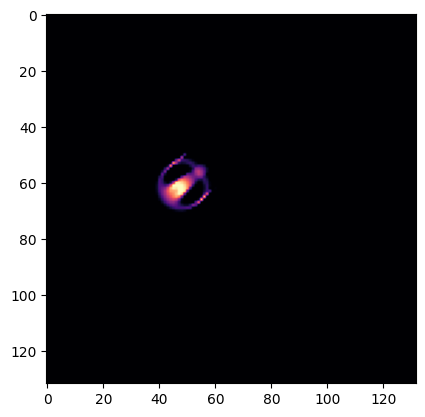

In [3]:
# common setup for O. unicaudatus

# the neighborhood kernel
amplitudes = [1.0]
means = [0.5]
standard_deviations = [0.15]
kernel_radius = 13

make_kernel = make_make_kernel_function(amplitudes, means, standard_deviations,dim=122)
kernel = make_kernel(kernel_radius)

# the growth function
mean_g = 0.15
standard_deviation_g = 0.017

clipping_fn = lambda x: np.clip(x,0,1.0)
my_update = make_update_function(mean_g, standard_deviation_g)


pattern_filepath = os.path.join("..", "patterns", "orbium_unicaudatus.npy")

pattern = np.load(pattern_filepath)
if(0):
    plt.figure()
    plt.imshow(kernel.squeeze())
    plt.figure()
    plt.plot(np.arange(0,1.0,0.001), my_update(np.arange(0,1.0,0.001)))
    plt.figure()
    plt.imshow(pattern.squeeze(), cmap="magma")

grid_dim = 132
num_frames = 12
dts = 0.1
clipping_fn = lambda x: np.clip(x, 0, 1.0)

update_step = make_update_step(my_update, kernel, dts, clipping_fn)

grid = np.zeros((1, 1, grid_dim, grid_dim))
grid = grid.at[:,:,45:45+pattern.shape[-2], 45:45+pattern.shape[-1]].set(pattern)

fig, ax = get_fig(grid[0])
plt.close()

IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update_frame, frames=num_frames, interval=10).to_jshtml())

In [ ]:
min_dt = 0.01 #0.13230
max_dt = 1.0 #0.13235
min_kr = 5 #8.6563
max_kr = 51 #8.6568


min_dt = 0.1212
max_dt = 0.1470
min_kr = 8.59
max_kr = 9.67

number_dt_steps = 128
number_kr_steps = 128
stride = 16

max_t = 32
max_steps = 3200
max_growth = 2.
min_growth = 0.5
k0 = 13
grid_dim = 128
kernel_dim = 122

make_kernel = make_make_kernel_function(amplitudes, means, standard_deviations, dim=kernel_dim)


parameter_steps = 8
stride = min([16, parameter_steps])
max_t = 32
max_steps =3200

results = []
t0 = time.time()
"""\
(5, 53, 0.001, 1.05),\
(8, 13, 0.1, 0.2),\
(8.5, 9.0, 0.13, 0.14),\
(8.655, 8.665, 0.1335, 0.1345),\
(8.6565, 8.6570, 0.1337, 0.1338),\
            
"""
for idx, params in enumerate([(5, 53, 0.001, 1.05),\
        (8, 13, 0.1, 0.2),\
        (8.5, 9.0, 0.13, 0.14),\
        (8.655, 8.665, 0.1335, 0.1345),\
        (8.6565, 8.6570, 0.1337, 0.1338),\
        (8.6566, 8.6567, 0.133725, 0.1338)\
              ]):
    
    min_kr = params[0]
    max_kr = params[1]
    min_dt = params[2]
    max_dt = params[3]
    
    t1 = time.time()
    results.append(v_stability_sweep(pattern, make_kernel, my_update, \
            max_t=max_t, max_steps=max_steps, parameter_steps=parameter_steps, stride=stride,\
            min_dt=min_dt, max_dt=max_dt,\
            min_kr = min_kr, max_kr=max_kr))
    t2 = time.time()

    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.imshow(results[-1][0])
    dts = np.arange(min_dt, max_dt, (max_dt-min_dt) / parameter_steps)
    krs = np.arange(min_kr, max_kr, (max_kr-min_kr) / parameter_steps)
    _ = ax.set_xticks(np.arange(0,dts.shape[0]))
    _ = ax.set_xticklabels([f"{elem.item():.6e}" for elem in dts], rotation=90)
    _ = ax.set_yticks(np.arange(0,krs.shape[0]))
    _ = ax.set_yticklabels([f"{elem.item():.6e}" for elem in krs], rotation=0)
    _ = ax.set_xlabel("step size dt")
    _ = ax.set_ylabel("kernel radius")
    
    msg2 = f"total elapsed: {t2-t0:.3f} s, last sweep: {t2-t1:.3f}\n"
    msg = f"    dt from {min_dt:.2e} to {max_dt:.2e}\n"
    msg += f"    kr from {min_kr:2e} to {max_kr:.2e}\n"
    
    ax.set_title("disco persistence \n" +msg, fontsize=32)
    plt.savefig(f"../assets/disco_{idx}.png")
    plt.show() 
    
    print(msg2 + msg)

In [17]:
1440/60


24.0

# SmoothLife glider

In [ ]:

pattern_filepath = os.path.join("..", "patterns", "smoothlife_single.npy")

pattern = np.load(pattern_filepath)[None,None,:,:]
plt.figure()
plt.imshow(pattern.squeeze(), cmap="magma")
plt.title("pattern")
plt.show()

In [ ]:
num_frames = 100
kr = 10
k0 = 10
dt= 1.0
grid_dim = 132

k0 = 10
r_inner = 1/3.
r_outer = 1.05

gen = make_smooth_interval(alpha=0.028, intervals=[[0.2780, 0.3650]])
per = make_smooth_interval(alpha=0.1470, intervals=[[0.2670, 0.4450]])

make_sl_kernel = make_make_smoothlife_kernel_function(r_inner, r_outer,dim = 126)
make_sl_inner_kernel = make_make_smoothlife_kernel_function(0.0, r_inner, dim = 126)

inner_kernel = make_sl_inner_kernel(k0)
kernel = make_sl_kernel(kr)

update_step = make_smoothlife_update_step(gen, per, \
        kernel, inner_kernel, dt, \
        clipping_function = lambda x: np.clip(x, 0, 1.0), \
        decimals=None)


scale_factor = kr / k0
native_dim_h = pattern.shape[-2]
native_dim_w = pattern.shape[-1]
dim_h = int(native_dim_h * scale_factor)
dim_w = int(native_dim_w * scale_factor)
        
scaled_pattern = skimage.transform.resize(pattern, (1,1, dim_h, dim_w),order=5)

grid = np.zeros((1, 1, grid_dim, grid_dim))
grid = grid.at[:,:,:scaled_pattern.shape[-2], :scaled_pattern.shape[-1]].set(scaled_pattern)

fig, ax = get_fig(grid[0])
plt.show()

IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update_frame, frames=num_frames, interval=10).to_jshtml())

# _H. natans_

In [ ]:
# common setup for H. natans

# the neighborhood kernel
amplitudes = [0.5, 1.0, 0.6667]
means = [0.0938, 0.2814, 0.4690]
standard_deviations = [0.0330, 0.0330, 0.0330]
kernel_radius = 31

make_kernel = make_make_kernel_function(amplitudes, means, standard_deviations)
kernel = make_kernel(kernel_radius)

# the growth function
mean_g = 0.26
standard_deviation_g = 0.036

clipping_fn = lambda x: np.clip(x,0,1.0)
my_update = make_update_function(mean_g, standard_deviation_g)


# The Platonic Pattern: _Hydrogeminium natans_ pickle

In [ ]:
pattern_filepath = os.path.join("..", "patterns", "hydrogeminium_natans_pickle.npy")

pattern = np.load(pattern_filepath)[None,None,:,:]
plt.figure()
plt.imshow(pattern.squeeze(), cmap="magma")


In [ ]:
number_samples = 1
dim = 256
grid = np.zeros((number_samples,1,dim,dim))
grid = grid.at[:,:,:pattern.shape[-2], :pattern.shape[-1]].set(pattern)

dts = 0.1

clipping_fn = lambda x: np.clip(x,0,1.0)
update_step = make_update_step(my_update, kernel, dts, clipping_fn, decimals=32)

num_frames = 100

fig, ax = get_fig(grid[0])
plt.show()

IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update_frame, frames=num_frames, interval=10).to_jshtml())

In [ ]:
min_dt = 0.001
max_dt = 0.2
number_dt_steps = 4
min_kr = 25
max_kr = 33
number_kr_steps = 4

for number_steps in [4]:
    number_dt_steps = 512
    number_kr_steps = 4
    dts = np.arange(min_dt, max_dt, (max_dt-min_dt) / number_dt_steps)[:,None,None,None]
    krs = np.arange(min_kr, max_kr, (max_kr-min_kr) / number_kr_steps)
    max_t = dts.max() * 100
    
    number_samples = 1
    dim = 128
    grid = np.zeros((number_dt_steps,number_kr_steps,dim,dim))
    grid = grid.at[:,:,:pattern.shape[-2], :pattern.shape[-1]].set(pattern)
    
    kernel_dim = 125
    make_kernel = make_make_kernel_function(amplitudes, means, standard_deviations, dim=kernel_dim)
    
    kernels = np.zeros((1, number_kr_steps, kernel_dim+1, kernel_dim+1))
    
    for ii in range(number_kr_steps):
        kernels = kernels.at[:,ii:ii+1,:,:].set(make_kernel(krs[ii]))

    
    update_step = make_update_step(my_update, kernels, dts, clipping_fn)

    t0 = time.time()
    for step in range(1000):
        grid = update_step(grid)
        
    t1 = time.time()

    print(f"time elapsed = {t1-t0:.3f} for ndt x nkr = {dts.shape[0]} x {kernels.shape[1]}")
    print(f" \t {1000 * (dts.shape[0] *kernels.shape[1]) / (t1-t0):.4f} grid updates/second")

In [ ]:
# old notes, checking vectorization
min_dt = 0.001
max_dt = 0.2
number_dt_steps = 4
min_kr = 5
max_kr = 63
number_kr_steps = 4

dts = np.arange(min_dt, max_dt, (max_dt-min_dt) / number_dt_steps)[:,None,None,None]
krs = np.arange(min_kr, max_kr, (max_kr-min_kr) / number_kr_steps)
max_t = dts.max() * 100

number_samples = 1
dim = 256
grid = np.zeros((number_dt_steps,number_kr_steps,dim,dim))
grid = grid.at[:,:,:pattern.shape[-2], :pattern.shape[-1]].set(pattern)

kernel_dim = 124
make_kernel = make_make_kernel_function(amplitudes, means, standard_deviations, dim=kernel_dim)

kernels = np.zeros((1, number_kr_steps, kernel_dim+1, kernel_dim+1))

for ii in range(number_kr_steps):
    kernels = kernels.at[:,ii:ii+1,:,:].set(make_kernel(krs[ii]))

if(0):
    plt.imshow(kernel.squeeze())
    plt.show()

update_step = make_update_step(my_update, kernel, dts, clipping_fn)

for step in range(100):
    grid = update_step(grid)

plt.figure()
plt.subplot(221)
plt.imshow(grid[0,0])
plt.subplot(222)
plt.imshow(grid[1,0])
plt.subplot(223)
plt.imshow(grid[2,0])
plt.subplot(224)
plt.imshow(grid[3,0])
plt.show()


plt.figure()
plt.subplot(221)
plt.imshow(kernels[0,0])
plt.subplot(222)
plt.imshow(kernels[0,1])
plt.subplot(223)
plt.imshow(kernels[0,2])
plt.subplot(224)
plt.imshow(kernels[0,3])
plt.show()

kernel.shape

# The Non-Platonic _H. natans_ wobbler

In [ ]:
#
pattern_filepath = os.path.join("..", "patterns", "hydrogeminium_natans_wobbler.npy")

pattern = np.load(pattern_filepath)[None,None,:,:]
plt.figure()
plt.imshow(pattern.squeeze(), cmap="magma")


In [ ]:
number_samples = 1
dim = 256
grid = np.zeros((number_samples,1,dim,dim))
grid = grid.at[:,:,:pattern.shape[-2], :pattern.shape[-1]].set(pattern)

dts = 0.38

clipping_fn = lambda x: np.clip(x,0,1.0)
update_step = make_update_step(my_update, kernel, dts, clipping_fn, decimals=32)

num_frames = 100

fig, ax = get_fig(grid[0])
plt.show()

IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update_frame, frames=num_frames, interval=10).to_jshtml())